In [13]:
import numpy as np
import halotools
import matplotlib
import matplotlib.pyplot as plt
import time

from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.sim_manager import CachedHaloCatalog

model = PrebuiltHodModelFactory('zheng07')
bolshoi_z0 = CachedHaloCatalog()
halos = bolshoi_z0.halo_table

In [2]:
bolshoi_m200b = np.sort(np.array(halos['halo_m200b'])) # list of 200x-background masses for Bolshoi catalog

In [3]:
# function which returns galaxy number density using current parameter values
def gal_density():

    temp_mean_ncen = model.mean_occupation_centrals(prim_haloprop = bolshoi_m200b)
    temp_mean_nsat = model.mean_occupation_satellites(prim_haloprop = bolshoi_m200b)
    
    temp_total_galaxies = sum(temp_mean_ncen) + sum(temp_mean_nsat) # add all list elements to count total galaxies
    temp_density = temp_total_galaxies/(250**3) # galaxy number density in (h^{-1} Mpc)^{-3}
    
    return temp_density

# function which uses bisection method to find logMmin which achieves goal_density at current values of other params
def bisect(minval, maxval, goal_density, threshold):
    
    model.param_dict['logMmin'] = minval # set logMmin to lower bound to make sure density > goal_density
    max_gal_density = gal_density()
    
    if max_gal_density < goal_density:
        print(f"ERROR: gal_density for logMmin={minval} is {max_gal_density}, which is less than goal density of {goal_density}")
        return -1
    
    model.param_dict['logMmin'] = maxval # set logMmin to upper bound to make sure density < goal density
    min_gal_density = gal_density()
    
    if min_gal_density > goal_density:
        print(f"ERROR: gal_density for logMmin={maxval} is {min_gal_density}, which is greater than goal density of {goal_density}")
        return -1
    
    midpoint = (minval + maxval)/2
    model.param_dict['logMmin'] = midpoint
    mid_gal_density = gal_density()
    frac_error = np.abs((mid_gal_density - goal_density)/goal_density) # fractional error of current midpoint density

    if frac_error < threshold:
        return midpoint
    
    elif mid_gal_density > goal_density:
        return bisect(midpoint, maxval, goal_density, threshold)
    
    elif mid_gal_density < goal_density:
        return bisect(minval, midpoint, goal_density, threshold)
    
    else:
        print("ERROR: this should never happen")

In [25]:
# reset all Zheng parameters to fiducial values from Fermilab HOD paper
model.param_dict['logMmin'] = 12.36
model.param_dict['logM1'] = 13.69
model.param_dict['logM0'] = 8.35
model.param_dict['sigma_logM'] = 0.32
model.param_dict['alpha'] = 1.28

redmagic_density = 10**(-3)
density_error_threshold = 10**(-3) # fractional error upper bound
num_points = 200

logM1_lower = 13.46
logM1_upper = 16

logM1_list = np.linspace(logM1_lower, logM1_upper, num_points) # list of values of logM1 to loop through
logMmin_list = [] # empty list in which to place logMmin values which achieve goal density for each logM1

# wild upper, lower limits used to narrow search range in logMmin below (beyond least/most massive Bolshoi halos)
logMmin_wild_lower = 8
logMmin_wild_upper = 16

# determine lower end of logMmin range by finding req'd logMmin at upper end of logM1 range
model.param_dict['logM1'] = logM1_upper
logMmin_lower = 0.9*bisect(logMmin_wild_lower, logMmin_wild_upper, redmagic_density, density_error_threshold)

# determine upper end of logMmin range by finding req'd logMmin at lower end of logM1 range
model.param_dict['logM1'] = logM1_lower
logMmin_upper = 1.1*bisect(logMmin_wild_lower, logMmin_wild_upper, redmagic_density, density_error_threshold)

print(f'Setting logMmin search range to [{logMmin_lower},{logMmin_upper}]')

counter = 0
end = len(logM1_list)

start_time = time.process_time()

for current_logM1 in logM1_list:
    
    model.param_dict['logM1'] = current_logM1
    current_logMmin = bisect(logMmin_lower, logMmin_upper, redmagic_density, density_error_threshold)
    logMmin_list.append(current_logMmin)
    
    counter += 1
    
    elapsed_time = time.process_time() - start_time
    elapsed_mins, elapsed_secs = divmod(elapsed_time, 60)
    elapsed_print = '{:02d}:{:02d}'.format(round(elapsed_mins), round(elapsed_secs))
    
    print(f"{counter}/{end} points complete in {elapsed_print}", end='\r')

Setting logMmin search range to [11.449511718750001,16.087500000000002]


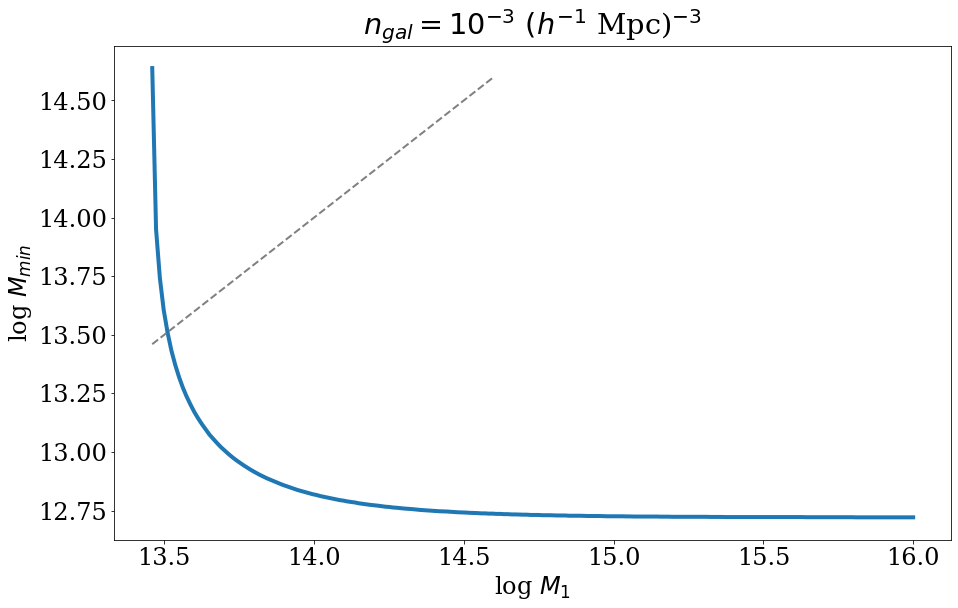

In [28]:
plt.rcParams.update({
    'lines.linewidth':2.0,
    'font.family':'serif',
    'font.size': 24,
    'legend.fontsize':20,
    'legend.frameon':False})

# Plot
fig = plt.figure()
fig.set_size_inches(15, 20)
ax = fig.add_subplot(2, 1, 1)

plt.plot(logM1_list, logMmin_list, linewidth = 4)
plt.plot([logM1_lower, 14.6], [logM1_lower, 14.6], '--', color='gray')

plt.title('$n_{gal} = 10^{-3}\ (h^{-1}$ Mpc)$^{-3}$')
plt.xlabel('log $M_1$')
plt.ylabel('log $M_{min}$')

fig.patch.set_facecolor('white')

plt.show()